# Performance of the Solution Algorithms

## Test Data Source

To evaluate the different algorithms we'll need some test data. I'm using some test sets from [Peter Norvig's Sudoku Solver](https://norvig.com/sudoku.html), along with some additional sets:

* [50 Easy Puzzles](../data/sudoku_9x9/p096_sudoku.txt), sourced from [Project Euler](http://projecteuler.net/), [Sudoku Problem](http://projecteuler.net/index.php?section=problems&id=96)
* [Top 95](../data/sudoku_9x9/top95.txt), sourced from [here](http://magictour.free.fr/top95) and [here](https://raw.githubusercontent.com/horenmar/sudoku-example/master/inputs/benchmark/top95.txt).
* [Hardest](../data/sudoku_9x9/hardest.txt), which [Norvig sourced by hand](https://norvig.com/sudoku.html).
* [Hard 17-clue puzzles](../data/sudoku_9x9/sudoku17.txt), a collection of puzzles with only 17 starting clues collected by [Gordon Royle at The University of Western Australia](https://staffhome.ecm.uwa.edu.au/~00013890/sudokumin.php).


## Modules Required

We're using the [sudoku](../puzzle/sudoku.py) and [tester](../puzzle/tester.py) modules used elsewhere, as well as a small number of standard libraries. We have to make a slight adjustment to the notebook's environment in order to find these modules, since this notebook is in a sub-directory.

In [1]:
import sys
sys.path.insert(-1, '..')

import puzzle.tester as tester
import puzzle.sudoku as su
from puzzle.jupyter_helpers import *
display(HTML(SUDOKU_CSS))

## Other Modules

For the performance analysis we're using Pandas and MatPlotLib.


In [2]:
import copy
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 6]
pd.set_option('precision', 3)

---
# Performance Analysis

## Measuring Performance Times 

Using the `PuzzleTester` class we can load test cases from a file. The class can then run a "solver" against each test case and record the execution time. 

The code below loads some starting test cases from [sudoku.py](../puzzle/sudoku.py).

In [3]:
pt = tester.PuzzleTester(puzzle_class=su.SudokuPuzzle)
include_levels = ['Kids', 'Easy', 'Moderate', 'Hard']  # ['Diabolical', 'Pathalogical']
test_cases = [x for x in su.SAMPLE_PUZZLES if x['level'] in include_levels]
pt.add_test_cases(test_cases)

8

We can then loop through all the solver classes and `run_tests`.

In [4]:
for method in su.SOLVERS:
    solver = su.SudokuSolver(method=method)
    pt.run_tests(solver, label=method, callback=update_progress)

The `PuzzleTester` class holds the test results in a `dict` format suitable for creating a Pandas `DataFrame`. The simple helper function `show_results` below uses this to show a simple table of results for each test case.


In [5]:
def show_results(pt, axis=None):
    df = pd.DataFrame(pt.get_test_results())
    all_methods = list(pt.get_solver_labels())
    style1 = df.style.highlight_null()\
        .highlight_max(axis=axis, color='orange', subset=all_methods)\
        .highlight_min(axis=axis, color='green', subset=all_methods)\
        .format({m: '{:.3f}' for m in all_methods})
    return style1

show_results(pt)

,label,level,starting_clues,backtracking,constraintpropogation,deductive,sat
0,SMH 1,Kids,31,0.003,0.002,0.004,0.023
1,SMH 2,Easy,24,0.240,0.006,0.006,0.033
2,KTH 1,Easy,30,0.013,0.002,0.004,0.022
3,Rico Alan Heart,Easy,22,0.139,0.053,0.016,0.022
4,SMH 3,Moderate,26,0.085,0.023,0.065,0.021
5,SMH 4,Hard,22,1.361,0.034,0.034,0.023
6,SMH 5,Hard,25,0.594,0.036,0.035,0.033
7,Greg [2017],Hard,21,0.609,0.067,0.088,0.043



## Generating Performance Data

If the test results file exists we'll use the results from earlier. Otherwise, this will re-run all the tests which took ~3.5 hours on my 2017 Macbook Pro (2.3 GHz Intel Core i5).

* The results are saved in Pickle format
* Each test case is run `NUM_SAMPLES` times and the results averaged. Interestingly, there can be [quite some variation in some test cases](Constraint+Propogation+Variability.ipynb)
* All test files are in [data/sudoku_9x9](../data/sudoku_9x9/README.md)

The "difficulty levels" aren't really meaningful any more. They come from the levels given by the SMH in its Sudoku puzzles, but the other test puzzles aren't rated this way, and there's no real standard being used.


In [6]:
import os.path
import datetime

TEST_RESULTS = "../data/sudoku_test_results.pkl"
NUM_SAMPLES = 5

pt = tester.PuzzleTester(puzzle_class=su.SudokuPuzzle, test_samples=NUM_SAMPLES)
pt.add_test_cases([x for x in su.SAMPLE_PUZZLES])
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/p096_sudoku.txt", level="Easy"))
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/hardest.txt", level="Hard"))
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/top95.txt", level="Diabolical"))
pt.add_test_cases(tester.from_file("../data/sudoku_9x9/sudoku17_50.txt", level="Pathalogical"))
print(f"Using {pt.num_test_cases()} test cases")

if os.path.isfile(TEST_RESULTS):
    df = pd.read_pickle(TEST_RESULTS)
    print(f"Read previous test results from {TEST_RESULTS} from {datetime.datetime.fromtimestamp(os.path.getmtime(TEST_RESULTS))}")
    pt.set_test_results(df.to_dict('list'))

else:
    print(f"Generating {TEST_RESULTS} at {datetime.datetime.now()}...")
    for m in su.SOLVERS:
        solver = su.SudokuSolver(method=m)
        pt.run_tests(solver, m, callback=update_progress)
    df = pd.DataFrame(pt.get_test_results())
    df.to_pickle(TEST_RESULTS)
    print(f"Saved {TEST_RESULTS} at {datetime.datetime.now()}")


Using 225 test cases
Read previous test results from ../data/sudoku_test_results.pkl from 2020-11-02 03:27:31.527752


## Results summary

In [7]:
df.describe()

,starting_clues,backtracking,constraintpropogation,deductive,sat
count,225.000,225.000,225.000,225.000,225.000
mean,21.893,36.057,0.472,0.154,0.018
std,5.045,111.391,1.332,0.574,0.002
min,17.000,0.001,0.001,0.001,0.016
25%,17.000,0.155,0.006,0.009,0.017
50%,22.000,1.621,0.050,0.015,0.018
75%,25.000,20.448,0.252,0.055,0.018
max,39.000,1122.885,11.791,5.082,0.036


Some quick observatiobs:

* Backtracking alone is appalling. Look it:
 * 75% of the test cases are solved in ~0.2 seconds with the constraint propogation solution, but we need ~12 seconds using backtrackng alone.
 * Mean time is terrible for backtracking alone (~46 seconds).
 * Standard deviation is wide, because the performance is so variable
* The SAT solver is pretty fast, and its performance is also a lot more consistent. That kind of makes sense now because the number of boolean propositions that have to be satisfied for any given puzzle doesn't actually change that much.
* Constraint Propogation is the overall best performer from my own code, but it seems to pay to try and deduce a few cells first. This makes sense as well, because each cell that can be definitively solved can cut the search space significantly.

You can see the variability between the methods better with the following plot.

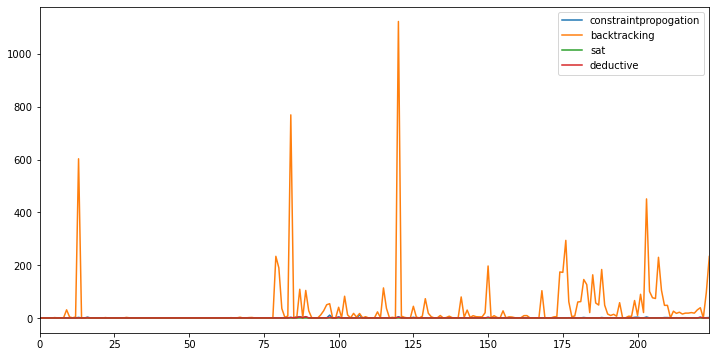

In [8]:
all_methods = list(pt.get_solver_labels())
ax = df[all_methods].plot()
#ax.set_facecolor("#161716")

The scale of backtracking obscures the differences between the other methods. 

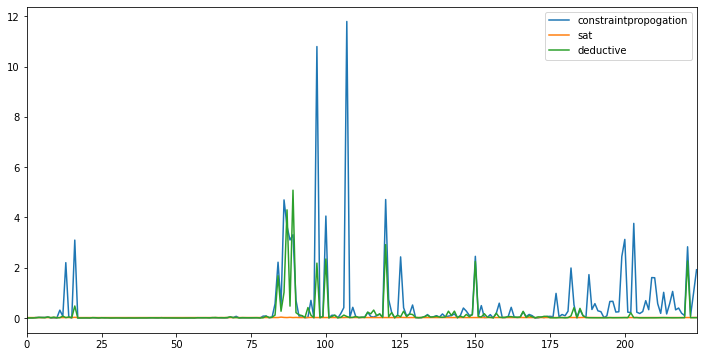

In [9]:
all_methods.remove('backtracking')
axs = df[all_methods].plot()

So this just seems to fit the same pattern, but because constraint propogation dramatically cuts the search space, the performance is generally faster. Those "spikes" are where a particular guess turns out to be *really bad* and there is a lot of backtracking to do.

You can also see the effect of the deductive solver. By solving a few cells straight away we cut the search space -- but there's still the occassional "bad guess" that triggers some backtracking.

A better visualisation tool for this kind of data might be a [boxplot](http://vita.had.co.nz/papers/boxplots.pdf).

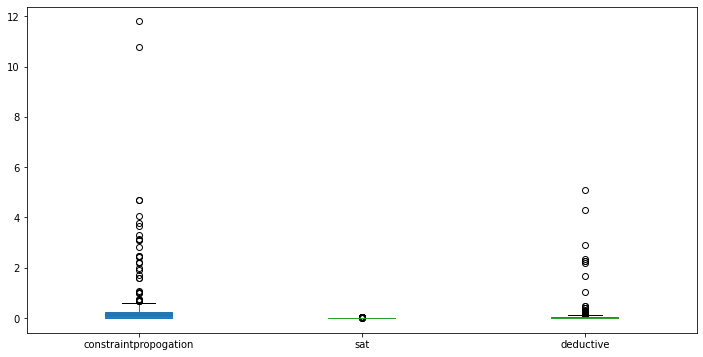

In [10]:
ax = df[all_methods].plot(kind='box', patch_artist=True)

Actually, the boxplot is a terrible choice because the scale of times for constraint propogation flattens the sat boxplot to a very thin pancake.

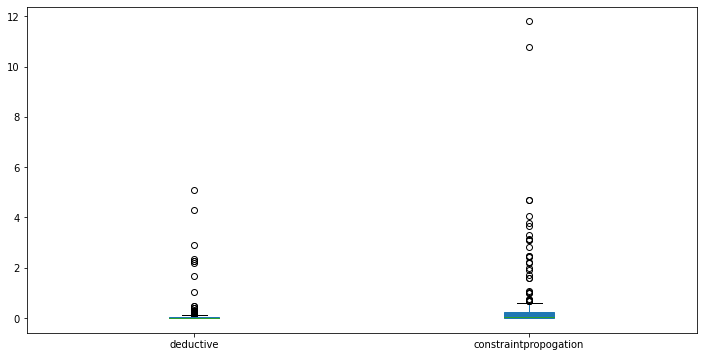

In [11]:
ax = df[['deductive', 'constraintpropogation']].plot(kind='box', patch_artist=True)

Above chart shows how the performace of the SAT solver is consistently fast. I admit I don't fully understand the code, since I'm relying on [pycosat](https://pypi.org/project/pycosat/) for the SAT part, and cribbing [implementation details](https://github.com/ContinuumIO/pycosat/blob/master/examples/sudoku.py) from [Ilan Schnell](http://ilan.schnell-web.net/prog/sudoku/) for generating the clauses. The conversion of a puzzle to a set of boolean clauses I eventually understood -- but the actual SAT solution algorithm is confusing me still.

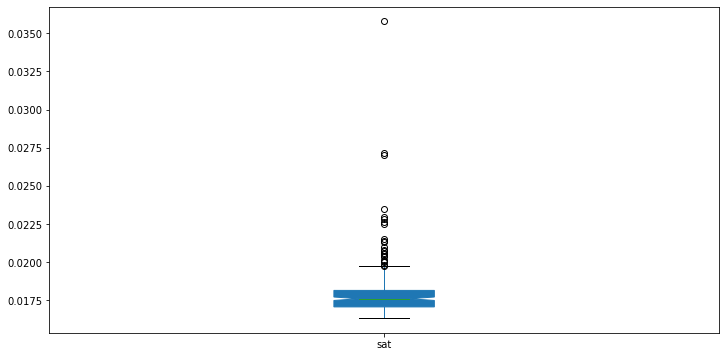

In [12]:
axs = df['sat'].plot(kind="box", notch=True, patch_artist=True)

So there is *some* variability in performance, just not a lot. Should also mention that `pycosat` is a wrapper around a C library called PicoSAT, which would be one reason why it's so much faster (that, and about 20 years of academic research on SAT solvers)!